# Logistic Regression Model Development with Hyperparameter Optimization

## Import Libraries

In [1]:
# records and calculations
import pandas as pd
import numpy as np

# visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# core ML
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, average_precision_score, classification_report, precision_recall_curve, confusion_matrix
from sklearn.metrics import roc_curve, auc, accuracy_score, f1_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler

# Persistence
import joblib
import pickle

# avoid minor warnings
import warnings
warnings.filterwarnings('ignore')

# read file path
from pathlib import Path

## Load Dataset and Saved Artifacts

In [2]:
# dataset path
file = Path(r"../data/CleanedLoanData.csv")

# artifacts path
artifacts_dir = Path(r"../artifacts/feature-selection")

# model performance path
model_performance_dir = Path(r"../artifacts/model-performance")

# models path
model_dir = Path(r"../artifacts/models")


In [3]:
# laod dataset
df = pd.read_csv(file)

In [4]:
# feature-target separation
x = df.drop(columns=['LoanStatus'])
y = df['LoanStatus']

In [5]:
# load artifacts
x_train = joblib.load(artifacts_dir / "x_train.pkl")
x_test = joblib.load(artifacts_dir / "x_test.pkl")
y_train = joblib.load(artifacts_dir / "y_train.pkl")
y_test = joblib.load(artifacts_dir / "y_test.pkl")
cv = joblib.load(artifacts_dir / "cv.pkl")

# configure socring metrics
scoring_metrics = 'roc_auc'

## Model Training with Hyperparameter Optimization

In [6]:
# hyperparameter grid
lr_param_grid = {
    'C' : [0.1, 1, 10, 100],
    'penalty': ['l2', 'l1'],
    'solver': ['liblinear'],
    'class_weight': ['balanced']
}

In [7]:
# Initialize model
lr = LogisticRegression(random_state=42, max_iter=1000)

# GridSearch Optimization
lr_grid = GridSearchCV(
    lr,
    lr_param_grid,
    cv=cv,
    scoring=scoring_metrics,
    n_jobs=-1
)

In [8]:
# train model and identify best estimator
lr_grid.fit(x_train, y_train)

best_model = lr_grid.best_estimator_

## Apply Model to Make Prediction and Get Probabilities

In [9]:
# make prediction on training and test set
train_pred = best_model.predict(x_train)
test_pred = best_model.predict(x_test)

In [10]:
# get predicted probabilities
train_proba = best_model.predict_proba(x_train)[:, 1]
test_proba = best_model.predict_proba(x_test)[:, 1]

## Evaluating Model Performance

In [11]:
# Training Metrics
train_auc_roc = roc_auc_score(y_train, train_proba)             # ROC-AUC score
train_auc_pr = average_precision_score(y_train, train_proba)    # average precision
train_acc = accuracy_score(y_train, train_pred)                 # accuracy score
train_precision = precision_score(y_train, train_pred)          # precision score
train_recall = recall_score(y_train, train_pred)                # recall score
train_f1 = f1_score(y_train, train_pred)                        # f1 score

In [12]:
# Test Metrics
test_auc_roc = roc_auc_score(y_test, test_proba)             # ROC-AUC score
test_auc_pr = average_precision_score(y_test, test_proba)    # average precision
test_acc = accuracy_score(y_test, test_pred)                 # accuracy score
test_precision = precision_score(y_test, test_pred)          # precision score
test_recall = recall_score(y_test, test_pred)                # recall score
test_f1 = f1_score(y_test, test_pred)                        # f1 score

### Performance Report for Training and Test Set

In [13]:
# classification report for train set
print("=== Performance on Training Set ===".center(55, '='))
train_report = classification_report(y_train, train_pred)
print(train_report)


============= Performance on Training Set =============
              precision    recall  f1-score   support

           0       0.64      0.56      0.60       153
           1       0.81      0.85      0.83       335

    accuracy                           0.76       488
   macro avg       0.72      0.71      0.71       488
weighted avg       0.76      0.76      0.76       488



In [14]:
# classification report for test set
print("=== Performance on Test Set ===".center(55, '='))
test_report = classification_report(y_test, test_pred)
print(test_report)

=============== Performance on Test Set ===============
              precision    recall  f1-score   support

           0       0.71      0.74      0.72        39
           1       0.88      0.86      0.87        84

    accuracy                           0.82       123
   macro avg       0.79      0.80      0.80       123
weighted avg       0.82      0.82      0.82       123



### Performance Metrics

In [15]:
# model status & gap generalization
model_status = 'Good' if test_acc > 0.85 else 'Fair' if test_acc > 0.75 else 'Needs Improvement'
generalization = 'Overfitting' if train_acc - test_acc > 0.05 else 'Best Fit'

# performance table
performance_df = pd.DataFrame({
    'Metric': [
        'AUC-ROC',
        'AUC-PR',
        'Precision',
        'Recall',
        'F1-Score',
        'Accuracy',
        'Generalization',
        'Model Status'
    ],
    'Training': [
        f"{train_auc_roc:.3f}",
        f"{train_auc_pr:.3f}",
        f"{train_precision:.3f}",
        f"{train_recall:.3f}",
        f"{train_f1:.3f}",
        f"{train_acc:.3f}",
        '-',
        '-'
    ],
    'Test': [
        f"{test_auc_roc:.3f}",
        f"{test_auc_pr:.3f}",
        f"{test_precision:.3f}",
        f"{test_recall:.3f}",
        f"{test_f1:.3f}",
        f"{test_acc:.3f}",
        '-',
        model_status
    ],
    'Gap/Generalization': [
        f"{abs(train_auc_roc - test_auc_roc):.3f}",
        f"{abs(train_auc_pr - test_auc_pr):.3f}",
        f"{abs(train_precision - test_precision):.3f}",
        f"{abs(train_recall - test_recall):.3f}",
        f"{abs(train_f1 - test_f1):.3f}",
        f"{abs(train_acc - test_acc):.3f}",
        generalization,
        '-'
    ]
})

In [16]:
# performance table
print("=== Logistic Regression Performance Metrics ===".center(52, '='))
performance_df

===== Logistic Regression Performance Metrics ======


,Metric,Training,Test,Gap/Generalization
0,AUC-ROC,0.777,0.879,0.102
1,AUC-PR,0.858,0.923,0.065
2,Precision,0.810,0.878,0.068
3,Recall,0.854,0.857,0.003
4,F1-Score,0.831,0.867,0.036
5,Accuracy,0.762,0.821,0.059
6,Generalization,-,-,Best Fit
7,Model Status,-,Fair,-


In [17]:
print("=== Metrics Summary ===")
print(f"Training Accuracy: {train_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Accuracy Gap: {abs(train_acc - test_acc):.4f} ({generalization})")
print(f"Model Performance: {model_status}")

=== Metrics Summary ===
Training Accuracy: 0.7623
Test Accuracy: 0.8211
Accuracy Gap: 0.0588 (Best Fit)
Model Performance: Fair


## ROC-Curve

In [18]:
# roc curve for training and testing set
train_fpr, train_tpr, _ = roc_curve(y_train, train_proba)
test_fpr, test_tpr, _ = roc_curve(y_test, test_proba)

In [19]:
# calculate AUC for training and testing set
train_auc = auc(train_fpr, train_tpr)
test_auc = auc(test_fpr, test_tpr)

**NOTE:** We can use training and test AUC-ROC (`roc_auc_score`) values to plot ROC curves

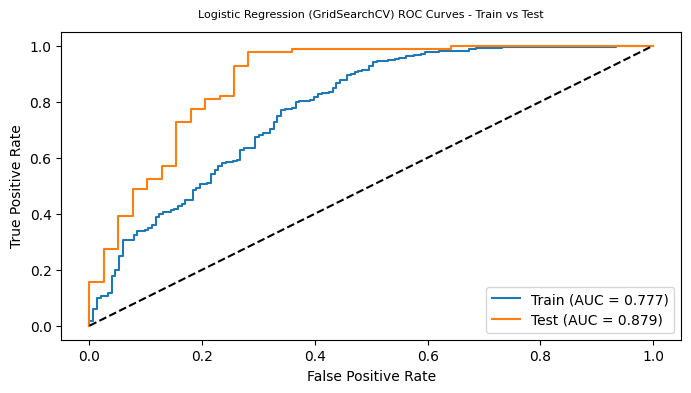

In [20]:
# figure size
plt.figure(figsize=(8, 4))

# ploting the curve
plt.plot(train_fpr, train_tpr, label=f'Train (AUC = {train_auc:.3f})')
plt.plot(test_fpr, test_tpr, label=f'Test (AUC = {test_auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--')

# set labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression (GridSearchCV) ROC Curves - Train vs Test',  y=1.02, fontsize=8)
plt.legend()
plt.show()

## Confusion Matrix

In [21]:
# confusion matrix for training and test set
train_cnf = confusion_matrix(y_train, train_pred)
test_cnf = confusion_matrix(y_test, test_pred)

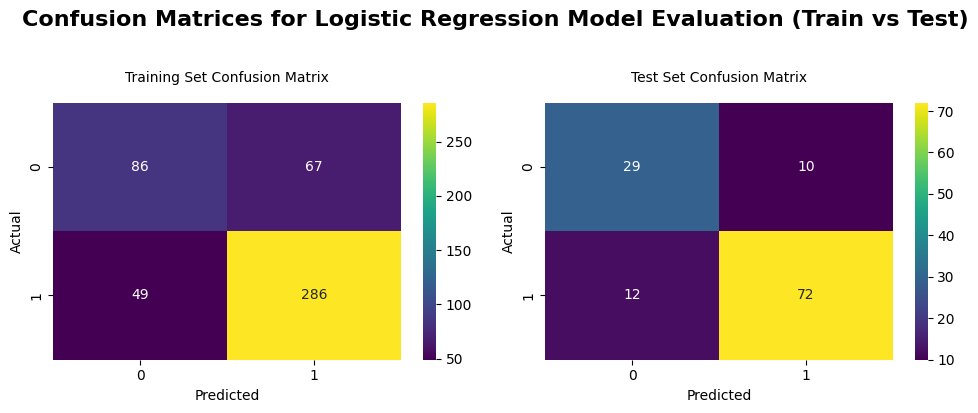

In [22]:
# visualize confusion matrices
# number of subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes = axes.flatten()

# confusion matrix for training set
ax = axes[0]
sns.heatmap(train_cnf, annot=True, fmt='d', cmap='viridis', ax=ax)

# set labels
ax.set_title("Training Set Confusion Matrix", fontsize=10, y=1.05)
ax.set_xlabel("Predicted")
ax.set_ylabel("Actual")


# confusion matrix for test set
ax = axes[1]
sns.heatmap(test_cnf, annot=True, fmt='d', cmap='viridis', ax=ax)

# set labels
ax.set_title("Test Set Confusion Matrix", fontsize=10, y=1.05)
ax.set_xlabel("Predicted")
ax.set_ylabel("Actual")

# ========== Layout ==========
plt.suptitle(f"Confusion Matrices for Logistic Regression Model Evaluation (Train vs Test)", y=1.02, fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

## Cross-Validation Scores

In [23]:
# calucate cross-validation scores
cv_scores = cross_val_score(best_model, x, y, cv=cv, scoring=scoring_metrics)
cv_mean = cv_scores.mean()
cv_std = cv_scores.std()

In [24]:
# create dataframe
cv_df = pd.DataFrame({
    "Model": "Logistic Regression (GridSearchCV)",
    "CV Mean": [cv_mean],
    "CV Std": [cv_std]
}).round(3)

In [25]:
cv_df

,Model,CV Mean,CV Std
0,Logistic Regression (GridSearchCV),0.776,0.028


## Overfitting Analysis

In [26]:
# overfitting gap
overfitting_gap = abs(train_auc_roc - test_auc_roc)

# overfitting status
overfit_status = "High" if overfitting_gap > 0.6 else "Medium" if overfitting_gap > 0.4 else "Low"

# overfitting dictionary
overfit_model = pd.DataFrame({
    'Model': ['Logistic Regression (GridSearchCV)'],
    'AUC-ROC Gap': [abs(train_auc_roc - test_auc_roc)],
    'AUC-PR Gap': [abs(train_auc_pr - test_auc_pr)],
    'Precision Gap': [abs(train_precision - test_precision)],
    'Recall Gap': [abs(train_recall - test_recall)],
    'F1-Score Gap': [abs(train_f1 - test_f1)],
    'Accuracy Gap': [abs(train_acc - test_acc)],
    'Overfitting Status': [overfit_status]
}).round(3)


In [27]:
print("=== Overfitting Analysis Table ===".center(130))
overfit_model

                                                === Overfitting Analysis Table ===                                                


,Model,AUC-ROC Gap,AUC-PR Gap,Precision Gap,Recall Gap,F1-Score Gap,Accuracy Gap,Overfitting Status
0,Logistic Regression (GridSearchCV),0.102,0.065,0.068,0.003,0.036,0.059,Low


## Model Scoring

In [28]:
""" Composite score (higher is better) """

# Weighted combination: 30% CV mean, 15% low CV std, 15% test acc, 15% F1, 15% AUC, 10% low overfitting
composite_score = (0.3 * cv_mean) + (0.15 * (1-cv_std)) + (0.15 * test_acc) + \
                      (0.15 * test_f1) + (0.15 * test_auc) + (0.1 * (1-overfitting_gap))

In [29]:
model_score = pd.DataFrame({
    'Model': ['Logistic Regression (GridSearchCV)'],
    'CV Mean': [cv_mean],
    'CV Std': [cv_std],
    'Test Accuracy': [test_acc],
    'Test F1-Score': [test_f1],
    'Test AUC': [test_auc_roc],
    'Overfitting Gap': [overfitting_gap],
    'Composite Score': [composite_score]
}).round(3)

In [30]:
print("=== Model Score Table ===".center(130))
model_score

                                                    === Model Score Table ===                                                     


,Model,CV Mean,CV Std,Test Accuracy,Test F1-Score,Test AUC,Overfitting Gap,Composite Score
0,Logistic Regression (GridSearchCV),0.776,0.028,0.821,0.867,0.879,0.102,0.853


## Persist Model and Final Performance Table

In [31]:
# overall model performance
perf_df = pd.DataFrame({
    'Model': ['Logistic Regression (GridSearchCV)'],
    'AUC-ROC': [test_auc_roc],
    'AUC-PR': [test_auc_pr],
    'Precision': [test_precision],
    'Recall': [test_recall],
    'F1-Score': [test_f1],
    'Accuracy': [test_acc],
    'CV AUC-ROC Mean': [cv_mean],
    'CV AUC-ROC Std': [cv_std],
    'AUC-ROC (Overfit) Gap': [overfitting_gap],
    'Composite Score': [composite_score],
    'Overfitting Status': [overfit_status],
    'Model Status': [model_status],
}).round(3)

In [32]:
perf_df

,Model,AUC-ROC,AUC-PR,Precision,Recall,F1-Score,Accuracy,CV AUC-ROC Mean,CV AUC-ROC Std,AUC-ROC (Overfit) Gap,Composite Score,Overfitting Status,Model Status
0,Logistic Regression (GridSearchCV),0.879,0.923,0.878,0.857,0.867,0.821,0.776,0.028,0.102,0.853,Low,Fair


In [33]:
# save model performance
performance_path = model_performance_dir / "logisticRegressionPerformance.csv"

# convert performance dataframe to csv
performance_df.to_csv(performance_path, index=False)

In [34]:
# save Cross Validation score for all models
cv_path = model_performance_dir / "a_CrossValidationScore.csv"

cv_df.to_csv(cv_path, index=False)

In [35]:
# overfitting analysis table
overfit_path = model_performance_dir / "a_OverfittingAnalysis.csv"

overfit_model.to_csv(overfit_path, index=False)

In [36]:
# add to model scores table
model_score_path = model_performance_dir / "a_ModelsScores.csv"

model_score.to_csv(model_score_path, index=False)

In [37]:
# model comparison table
model_perf_path = model_performance_dir / "a_ModelsPerformance.csv"

perf_df.to_csv(model_perf_path, index=False)


In [38]:
#  saved model and test probabilities
joblib.dump(best_model, model_dir / "logisticRegression.pkl")
np.save(model_dir / "logisticRegression_testProba.npy", test_proba)